In [1]:
import os
import glob
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TOGETHER_API_KEY"] = os.getenv("TOGETHER_API_KEY")
os.environ["MISTRAL_API_KEY"] = os.getenv("MISTRAL_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

In [2]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGSMITH_PROJECT"]="SQL AGENT"

In [3]:
import sqlite3

connection = sqlite3.connect('employee.db')

In [4]:
## Employee table creation
table_create_query = """
CREATE TABLE IF NOT EXISTS employee (
    emp_id INTEGER PRIMARY KEY,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    hire_date TEXT NOT NULL,
    salary REAL NOT NULL
);
"""
## Customer table creation
table_create_query2 = """
CREATE TABLE IF NOT EXISTS customer (
    customer_id INTEGER PRIMARY KEY,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    phone TEXT NOT NULL
);
"""

## Order table creation
table_create_query3 = """
CREATE TABLE IF NOT EXISTS orders (
    order_id INTEGER PRIMARY KEY,
    customer_id INTEGER NOT NULL,
    order_date TEXT NOT NULL,
    total_amount REAL NOT NULL,
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id)
);
"""

cursor = connection.cursor()

In [5]:
cursor.execute(table_create_query)
cursor.execute(table_create_query2)
cursor.execute(table_create_query3)

In [6]:
insert_employee_query = """
INSERT INTO employee (emp_id, first_name, last_name, email, hire_date, salary)
VALUES (?, ?, ?, ?, ?, ?);
"""

insert_customer_query = """
INSERT INTO customer (customer_id, first_name, last_name, email, phone)
VALUES (?, ?, ?, ?, ?);
"""

insert_order_query = """
INSERT INTO orders (order_id, customer_id, order_date, total_amount)
VALUES (?, ?, ?, ?);
"""

In [7]:
employee_data = [
    (1, 'John', 'Doe', 'john.doe@gmail.com', '2023-01-15', 60000.00),
    (2, 'Jane', 'Smith', 'jane@yahoo.com', '2023-02-20', 75000.00),
    (3, 'Alice', 'Johnson', 'alice@gmail.com', '2023-03-10', 50000.00),
    (4, 'Bob', 'Brown', 'bob@microsoft.com', '2023-04-05', 80000.00),
]

customer_data = [
    (1, 'Charlie', 'Davis', 'charlie.dav@gmail.com', '123-456-7890'),
    (2, 'Diana', 'Wilson', 'diana@yahoo.com', '987-654-3210'),
    (3, 'Ethan', 'Martinez', 'ethan@mgr.com', '555-123-4567'),
    (4, 'Fiona', 'Garcia', 'fiona.garcia@anime.com', '444-987-6543'),
]

order_data = [
    (1, 1, '2023-05-01', 150.00),
    (2, 2, '2023-05-02', 200.00),
    (3, 3, '2023-05-03', 300.00),
    (4, 4, '2023-05-04', 400.00),
]

In [8]:
cursor.executemany(insert_employee_query, employee_data)
cursor.executemany(insert_customer_query, customer_data)
cursor.executemany(insert_order_query, order_data)

In [9]:
connection.commit()

In [10]:
cursor.execute('select * from employee')
for row in cursor.fetchall():
    print(row)

(1, 'John', 'Doe', 'john.doe@gmail.com', '2023-01-15', 60000.0)
(2, 'Jane', 'Smith', 'jane@yahoo.com', '2023-02-20', 75000.0)
(3, 'Alice', 'Johnson', 'alice@gmail.com', '2023-03-10', 50000.0)
(4, 'Bob', 'Brown', 'bob@microsoft.com', '2023-04-05', 80000.0)


In [11]:
cursor.execute("select first_name, salary from employee where salary > 60000")
cursor.fetchall()

[('Jane', 75000.0), ('Bob', 80000.0)]

In [12]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
cursor.fetchall()

[('employee',), ('customer',), ('orders',)]

In [13]:
import os
from dotenv import load_dotenv

load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

In [14]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

In [18]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///employee.db")

In [19]:
print("Dialect:", db.dialect) ### Variant of SQL dialect
print("Tables:", db.get_usable_table_names())

Dialect: sqlite
Tables: ['customer', 'employee', 'orders']


In [20]:
query = db.run("SELECT * FROM employee WHERE salary > 60000")
print(query)

[(2, 'Jane', 'Smith', 'jane@yahoo.com', '2023-02-20', 75000.0), (4, 'Bob', 'Brown', 'bob@microsoft.com', '2023-04-05', 80000.0)]


In [21]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()
for tool in tools:
    print(tool.name + " - " + tool.description + "\n")

sql_db_query - Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema - Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables - Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker - Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [22]:
list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)
list_tables_tool

ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x00000140AA1B1D90>)

In [23]:
get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)
get_schema_tool

InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x00000140AA1B1D90>)

In [24]:
print(list_tables_tool.invoke(""))
print(get_schema_tool.invoke("customer"))

customer, employee, orders

CREATE TABLE customer (
	customer_id INTEGER, 
	first_name TEXT NOT NULL, 
	last_name TEXT NOT NULL, 
	email TEXT NOT NULL, 
	phone TEXT NOT NULL, 
	PRIMARY KEY (customer_id), 
	UNIQUE (email)
)

/*
3 rows from customer table:
customer_id	first_name	last_name	email	phone
1	Charlie	Davis	charlie.dav@gmail.com	123-456-7890
2	Diana	Wilson	diana@yahoo.com	987-654-3210
3	Ethan	Martinez	ethan@mgr.com	555-123-4567
*/


In [25]:
from langchain_core.tools import tool

@tool
def db_query_tool(query: str) -> str:
    """Run a SQL query against the database."""

    result = db.run_no_throw(query)
    if not result:
        return "No results found."
    
    return result

print(db_query_tool.invoke("SELECT * FROM employee WHERE salary > 60000"))

[(2, 'Jane', 'Smith', 'jane@yahoo.com', '2023-02-20', 75000.0), (4, 'Bob', 'Brown', 'bob@microsoft.com', '2023-04-05', 80000.0)]


In [26]:
from pydantic import BaseModel, Field
class FianlAnswer(BaseModel):
    """Submit the final answer to the user, based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user's question based on the query results.")

In [27]:
from typing import TypedDict, List, Annotated
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [28]:
from langchain_core.prompts import ChatPromptTemplate
template = """You are a SQL expert with a strong understanding of relational databases.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check. 
"""

prompt = ChatPromptTemplate.from_messages([("system", template), ("placeholder", "{messages}")])

query_check = prompt | llm.bind_tools([db_query_tool])

query_check.invoke({"messages": [("user", "SELECT * FROM employee WHERE salary > 60000")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q3m6k7mnw', 'function': {'arguments': '{"query":"SELECT * FROM employee WHERE salary \\u003e 60000"}', 'name': 'db_query_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 1087, 'total_tokens': 1183, 'completion_time': 0.174545455, 'prompt_time': 0.020865729, 'queue_time': 0.256458191, 'total_time': 0.195411184}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9518aef5-b9ee-4d84-8335-d6fc8d6d79fe-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM employee WHERE salary > 60000'}, 'id': 'q3m6k7mnw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1087, 'output_tokens': 96, 'total_tokens': 1183})

In [29]:
query_generation = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides FianlAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer."""


query_generation_prompt = ChatPromptTemplate.from_messages([("system", query_generation), ("placeholder", "{messages}")])

query_generation_tool = query_generation_prompt | llm.bind_tools([FianlAnswer])

In [30]:
from langchain_core.messages import AIMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode
from typing import Any, Literal

In [31]:
def initialize_db_discovery(state: State) -> dict[str, list[AIMessage]]:
    """Initialize the database discovery process by listing all available tables."""
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[{
                    "name": "sql_db_list_tables",
                    "args": {},
                    "id": "tool_abcd123"
                }]
            )
        ]
    }

In [32]:
def handle_tool_execution_error(state: State) -> dict:
    """Handle errors that occur during tool execution."""
    error = state.get("error") 
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\nPlease fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [33]:
def create_tool_node_with_error_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """Create a tool node with error handling fallback mechanism."""
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_execution_error)], 
        exception_key="error"
    )

In [34]:
def generate_sql_query_node(state: State):
    """Generate SQL query based on user input and handle incorrect tool calls."""
    message = query_generation_tool.invoke(state)

    # Handle cases where the LLM might call the wrong tool
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "FianlAnswer":  # Note: keeping original typo for consistency
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. "
                               f"Please fix your mistakes. Remember to only call FianlAnswer to submit the final answer. "
                               f"Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    
    return {"messages": [message] + tool_messages}

In [35]:
def route_after_query_generation(state: State) -> Literal[END, "validate_and_execute_query", "generate_sql_query"]:
    """Route to the next node based on the current state of query generation."""
    messages = state["messages"]
    last_message = messages[-1]
    
    # If tool calls exist, we're done (final answer submitted)
    if getattr(last_message, "tool_calls", None):
        return END
    
    # If there's an error, regenerate the query
    if last_message.content.startswith("Error:"):
        return "generate_sql_query"
    
    # Otherwise, validate and execute the query
    return "validate_and_execute_query"

In [36]:
def validate_sql_query(state: State) -> dict[str, list[AIMessage]]:
    """Validate the generated SQL query for correctness before execution."""
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

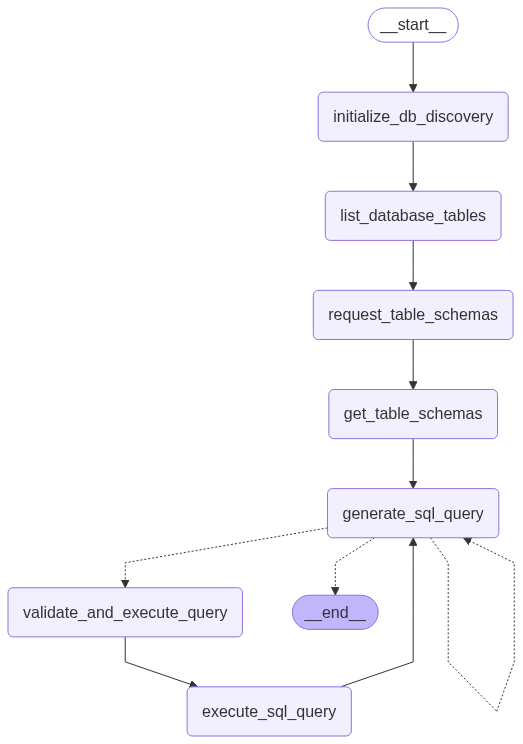

In [37]:
# Create the state graph
graph = StateGraph(State)

# Add nodes with descriptive names
graph.add_node("initialize_db_discovery", initialize_db_discovery)
graph.add_node("list_database_tables", create_tool_node_with_error_fallback([list_tables_tool]))
graph.add_node("get_table_schemas", create_tool_node_with_error_fallback([get_schema_tool]))

# Create model for schema retrieval
model_get_schema = llm.bind_tools([get_schema_tool])
graph.add_node(
    "request_table_schemas",
    lambda state: {"messages": [model_get_schema.invoke(state["messages"])]},
)

graph.add_node("generate_sql_query", generate_sql_query_node)
graph.add_node("validate_and_execute_query", validate_sql_query)
graph.add_node("execute_sql_query", create_tool_node_with_error_fallback([db_query_tool]))

# Define the workflow edges
graph.add_edge(START, "initialize_db_discovery")
graph.add_edge("initialize_db_discovery", "list_database_tables")
graph.add_edge("list_database_tables", "request_table_schemas")
graph.add_edge("request_table_schemas", "get_table_schemas")
graph.add_edge("get_table_schemas", "generate_sql_query")

# Add conditional routing after query generation
graph.add_conditional_edges("generate_sql_query", route_after_query_generation)

# Complete the workflow
graph.add_edge("validate_and_execute_query", "execute_sql_query")
graph.add_edge("execute_sql_query", "generate_sql_query")

# Compile the graph
builder = graph.compile()

builder

In [38]:
query={"messages": [("user", "Tell me name of all the employees who's salary is more than 30000?")]}
result = builder.invoke(query)
print(result["messages"][-1].tool_calls[0]["args"]["final_answer"])

John Doe, Jane Smith, Alice Johnson


In [39]:
db.run("SELECT first_name, last_name FROM employee WHERE salary > 30000")

"[('John', 'Doe'), ('Jane', 'Smith'), ('Alice', 'Johnson'), ('Bob', 'Brown')]"